In [9]:
# !apt-get install -y fonts-nanum

In [1]:
# Mecab 설치 (Colab, Jupyter 환경)
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh
%cd ..

# 기타 필요 라이브러리 설치
!pip install sentencepiece

print("\\n✅ 설치 완료! [런타임] > [런타임 다시 시작]을 실행하여 런타임을 재시작해주세요.")

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 138 (delta 26), reused 22 (delta 8), pack-reused 91 (from 1)
Receiving objects: 100% (138/138), 1.72 MiB | 7.35 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/home/jovyan/Mecab-ko-for-Google-Colab
install_mecab-ko_on_colab190912.sh: line 4: cd: /content: No such file or directory
Installing konlpy.....
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 72.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [konlpy]2m2/3 [konlpy]
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2025-09-07 21:57:26--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bit

In [2]:
#ko,konlpy는 설치되어있지만 python3가 설치되지 않아 연결이 안됨 따라서 이를 설치함
!pip install mecab-python3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.2/591.2 kB 1.1 MB/s eta 0:00:00ta 0:00:01


In [1]:
# -*- coding: utf-8 -*-
import os
import re
import shutil
import tarfile
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- PyTorch 라이브러리 ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- 토크나이저 및 형태소 분석기 ---
import sentencepiece as spm
from konlpy.tag import Mecab

# --- 시각화 라이브러리 ---
import matplotlib.pyplot as plt

# --- Mecab 설치 확인 ---
try:
    mecab = Mecab()
    print("✅ Mecab이 성공적으로 로드되었습니다.")
except Exception as e:
    print(f"❌ Mecab 로드 실패: {e}")
    print("-> 첫 번째 셀을 실행하고 '런타임 다시 시작'을 했는지 확인해주세요.")


# --- 기본 설정 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 디바이스: {device}")
print(f"PyTorch 버전: {torch.__version__}")

✅ Mecab이 성공적으로 로드되었습니다.
사용 디바이스: cuda
PyTorch 버전: 2.7.1+cu118


In [2]:
# --- 0. 기본 세팅 ---
import os, re, tarfile, shutil, unicodedata, random
import pandas as pd
from tqdm import tqdm

# 재현성 고정
random.seed(42)

# --- 1. 데이터 다운로드/압축 해제 (존재할 때는 건너뜀) ---
data_dir = 'korean-english-news-v1'
train_ko = os.path.join(data_dir, 'korean-english-park.train.ko')
train_en = os.path.join(data_dir, 'korean-english-park.train.en')
train_tar = os.path.join(data_dir, 'korean-english-park.train.tar.gz')

if not os.path.exists(data_dir):
    !git clone https://github.com/jungyeul/korean-parallel-corpora.git
    shutil.move('korean-parallel-corpora/korean-english-news-v1', './')
    shutil.rmtree('korean-parallel-corpora')

# 필요한 파일이 없으면 tar 해제
if not (os.path.exists(train_ko) and os.path.exists(train_en)):
    with tarfile.open(train_tar, 'r:gz') as tar:
        tar.extractall(path=data_dir)

# --- 2. 데이터 로딩 & 정제 ---
try:
    with open(train_ko, 'r', encoding='utf-8') as f:
        kor_raw = f.read().splitlines()
    with open(train_en, 'r', encoding='utf-8') as f:
        eng_raw = f.read().splitlines()

    # 길이 불일치 방지: 두 리스트를 같은 길이로 맞춤
    n = min(len(kor_raw), len(eng_raw))
    kor_raw, eng_raw = kor_raw[:n], eng_raw[:n]

    # DataFrame 생성 → 결측/중복 제거
    df = (
        pd.DataFrame({'kor': kor_raw, 'eng': eng_raw})
          .dropna()
          .drop_duplicates()
    )

    # 샘플링(필요할 때만)
    num_samples = 30000
    if len(df) > num_samples:
        df = df.sample(num_samples, random_state=42)

    print(f"데이터 로드 및 정제 완료. {len(df)}개의 샘플을 사용합니다.")

except Exception as e:
    print(f"오류: 데이터를 로드하는 중 문제가 발생했습니다 - {e}")
    df = pd.DataFrame()

# --- 3. 전처리 함수 정의 (한국어/영어) ---
# Mecab 준비
try:
    from konlpy.tag import Mecab
    mecab = Mecab()
except Exception as e:
    mecab = None
    print("⚠️ 경고: MeCab 초기화 실패. 한국어 형태소 분절이 비정상일 수 있습니다.", e)

# 한국어: 불필요 문자 제거 → 문장부호 분리 → 공백 정규화 → 형태소 분절
# ※ 기존 코드의 r\" \\1 \"는 역참조가 아닌 역슬래시를 남깁니다. 올바른 패턴은 r\" \1 \" 입니다.
_KO_KEEP_PUNCT = "?.!,"
_RE_KO_CLEAN = re.compile(rf"[^ㄱ-ㅎ가-힣0-9{re.escape(_KO_KEEP_PUNCT)}\s]+")

def _normalize_ws(s: str) -> str:
    return re.sub(r"\s+", " ", s).strip()

def preprocess_korean(sentence: str):
    # 1) 유니코드 정규화(NFKC)
    s = unicodedata.normalize("NFKC", sentence)

    # 2) 허용 문자 외 제거(이모지/한자/라틴 등 제거)
    s = _RE_KO_CLEAN.sub(" ", s)

    # 3) 문장부호 앞뒤에 공백 부여 (역참조는 \1 → 주의!)
    s = re.sub(rf"([{re.escape(_KO_KEEP_PUNCT)}])", r" \1 ", s)

    # 4) 공백 정규화
    s = _normalize_ws(s)

    # 5) 형태소 분절
    if mecab is None:
        # 비상 경로: 공백 토크나이즈 (권장 X)
        tokens = s.split()
    else:
        tokens = mecab.morphs(s)

    # 6) 빈 토큰 제거
    return [t for t in tokens if t.strip()]

# 영어: 소문자 → 문장부호 분리 → 공백 정규화 → 토큰 분할
def preprocess_english(sentence: str):
    s = sentence.lower().strip()
    s = re.sub(r"([?.!,])", r" \1 ", s)   # ✅ 역참조 올바르게 수정
    s = _normalize_ws(s)
    s = re.sub(r"[^a-z?.!,\s]+", " ", s)  # 영문/기호/공백만
    s = _normalize_ws(s)
    return s.split(' ')


def save_corpus(lines, path):
    # 문자열 리스트만 받도록 방어
    lines = [str(x) for x in lines if isinstance(x, (str, bytes)) or x is not None]
    # 공백 정리 + 빈 줄 제거
    lines = [_clean_line(x) for x in lines]
    lines = [x for x in lines if x]  # 빈 줄 제거
    # 중복 제거(선택)
    lines = list(dict.fromkeys(lines))
    # 너무 짧은 문장 제거(토큰 1개 이하 제거 – 선택)
    lines = [x for x in lines if len(x.split()) >= 2]

    with open(path, "w", encoding="utf-8") as f:
        for ln in lines:
            f.write(ln + "\n")

def _clean_line(s: str) -> str:
    s = re.sub(r"\s+", " ", s).strip()
    return s
    
# --- 4. 전처리 + 길이 필터링 ---
kor_corpus, eng_corpus = [], []

if not df.empty:
    max_len = 50  # 필요 시 조정
    # tqdm으로 진행상황 표시
    for ko, en in tqdm(zip(df['kor'].tolist(), df['eng'].tolist()), total=len(df)):
        if not isinstance(ko, str) or not isinstance(en, str):
            continue

        ko_tokens = preprocess_korean(ko)
        en_tokens = preprocess_english(en)

        if 0 < len(ko_tokens) <= max_len and 0 < len(en_tokens) <= max_len:
            # 아래처럼 ' '.join으로 이어두면 Keras Tokenizer(texts) 단계에서 그대로 처리하기 편함
            kor_corpus.append(' '.join(ko_tokens))
            eng_corpus.append(' '.join(en_tokens))

    print(f"\n✅ 전처리 및 길이 필터링 완료. 최종 {len(kor_corpus)}개 샘플.")
    if len(kor_corpus) > 0:
        print("전처리 예시:")
        print("Korean:", kor_corpus[0])
        print("English:", eng_corpus[0])
        save_corpus(kor_corpus, "kor_corpus.txt")
        save_corpus(eng_corpus, "eng_corpus.txt")

else:
    print("⚠️ 경고: 사용 가능한 데이터가 없습니다. 원본 파일을 확인하세요.")

Cloning into 'korean-parallel-corpora'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 176 (delta 20), reused 0 (delta 0), pack-reused 131 (from 1)
Receiving objects: 100% (176/176), 20.48 MiB | 18.28 MiB/s, done.
Resolving deltas: 100% (63/63), done.


/tmp/ipykernel_9957/46364943.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=data_dir)


데이터 로드 및 정제 완료. 30000개의 샘플을 사용합니다.


100%|██████████| 30000/30000 [00:05<00:00, 5838.79it/s]



✅ 전처리 및 길이 필터링 완료. 최종 28141개 샘플.
전처리 예시:
Korean: 은 1998 년 세상 에 공개 됐 다 .
English: fight the future .


In [3]:
# 말뭉치 파일로 저장
with open("kor_corpus.txt", "w", encoding="utf-8") as f:
    for line in kor_corpus:
        f.write(f"{line}\n")  # \\n -> \n 으로 수정

with open("eng_corpus.txt", "w", encoding="utf-8") as f:
    for line in eng_corpus:
        f.write(f"{line}\n")  # \\n -> \n 으로 수정

# SentencePiece 모델 학습
vocab_size = 8000
pad_id = 0
bos_id = 1
eos_id = 2
unk_id = 3

# 한국어(Source) 토크나이저
spm.SentencePieceTrainer.train(
    f'--input=kor_corpus.txt --model_prefix=kor_spm --vocab_size={vocab_size}'
    f' --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}'
)
# 영어(Target) 토크나이저
spm.SentencePieceTrainer.train(
    f'--input=eng_corpus.txt --model_prefix=eng_spm --vocab_size={vocab_size}'
    f' --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}'
)

# 토크나이저 로드
kor_tokenizer = spm.SentencePieceProcessor()
kor_tokenizer.load("kor_spm.model")

eng_tokenizer = spm.SentencePieceProcessor()
eng_tokenizer.load("eng_spm.model")

print("✅ 토크나이저 학습 완료!")

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=kor_corpus.txt --model_prefix=kor_spm --vocab_size=8000 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: kor_corpus.txt
  input_format: 
  model_prefix: kor_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  b

✅ 토크나이저 학습 완료!


 unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  differential_privacy_clipping_threshold: 0
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whitespaces: 1
  normalization_rule_tsv: 
}
denormalizer_spec {}
trainer_interface.cc(355) LOG(INFO) SentenceIterator is not specified. Using MultiFileSentenceIterator.
trainer_interface.cc(186) LOG(INFO) Loading corpus: kor_corpus.txt
trainer_interface.cc(411) LOG(INFO) Loaded all 28141 sentences
trainer_interface.cc(427) LOG(INFO) Adding meta_piece: <pad>
trainer_interface.cc(427) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(427) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(427) LOG(INFO) Adding meta_piece: <unk>
trainer_interface.cc(432) LOG(INFO) Normalizing sentences...
trainer_interface.cc(541) LOG(INFO) all chars count=2013947
trainer_interface.cc(552) LOG(INFO

In [4]:
class TranslationDataset(Dataset):
    def __init__(self, kor_corpus, eng_corpus, kor_tokenizer, eng_tokenizer, max_len):
        self.kor_corpus = kor_corpus
        self.eng_corpus = eng_corpus
        self.kor_tokenizer = kor_tokenizer
        self.eng_tokenizer = eng_tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 1
        self.eos_id = 2

    def __len__(self):
        return len(self.kor_corpus)

    def __getitem__(self, idx):
        src_text = self.kor_corpus[idx]
        trg_text = self.eng_corpus[idx]

        src_ids = [self.bos_id] + self.kor_tokenizer.encode(src_text) + [self.eos_id]
        trg_ids = [self.bos_id] + self.eng_tokenizer.encode(trg_text) + [self.eos_id]

        src_ids = src_ids[:self.max_len]
        trg_ids = trg_ids[:self.max_len]

        # 패딩 추가
        src_ids += [self.pad_id] * (self.max_len - len(src_ids))
        trg_ids += [self.pad_id] * (self.max_len - len(trg_ids))

        return torch.tensor(src_ids), torch.tensor(trg_ids)

# 데이터 분리 및 데이터 로더 생성
BATCH_SIZE = 64

# train_test_split을 위한 인덱스 생성
indices = list(range(len(kor_corpus)))
np.random.shuffle(indices)
split_point = int(len(indices) * 0.8)
train_indices, valid_indices = indices[:split_point], indices[split_point:]

# 코퍼스를 인덱스로 슬라이싱
train_kor_corpus = [kor_corpus[i] for i in train_indices]
train_eng_corpus = [eng_corpus[i] for i in train_indices]
valid_kor_corpus = [kor_corpus[i] for i in valid_indices]
valid_eng_corpus = [eng_corpus[i] for i in valid_indices]

train_dataset = TranslationDataset(train_kor_corpus, train_eng_corpus, kor_tokenizer, eng_tokenizer, max_len=max_len)
valid_dataset = TranslationDataset(valid_kor_corpus, valid_eng_corpus, kor_tokenizer, eng_tokenizer, max_len=max_len)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("데이터셋 및 데이터 로더 준비 완료!")
src_sample, trg_sample = next(iter(train_loader))
print("Train Loader 샘플 Shape (Source, Target):", src_sample.shape, trg_sample.shape)

데이터셋 및 데이터 로더 준비 완료!
Train Loader 샘플 Shape (Source, Target): torch.Size([64, 50]) torch.Size([64, 50])


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W1 = nn.Linear(hidden_dim, hidden_dim)
        self.W2 = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1)
        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention = self.v(energy).squeeze(2)
        return nn.functional.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim + hidden_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(emb_dim + hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        a = self.attention(hidden[-1], encoder_outputs).unsqueeze(1)
        context = torch.bmm(a, encoder_outputs)

        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)

        pred_input = torch.cat((embedded.squeeze(1), context.squeeze(1), output.squeeze(1)), dim=1)
        prediction = self.fc_out(pred_input)
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size, trg_len = trg.shape
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        encoder_outputs, hidden = self.encoder(src)

        input = trg[:, 0]
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            teacher_force = np.random.rand() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1
        return outputs

print("모델 클래스 정의 완료.")

모델 클래스 정의 완료.


In [11]:
# 모델 및 하이퍼파라미터 설정
INPUT_DIM = kor_tokenizer.get_piece_size()
OUTPUT_DIM = eng_tokenizer.get_piece_size()
EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
LEARNING_RATE = 0.001
N_EPOCHS = 10 # 시간 관계상 Epochs 줄임

# 모델 인스턴스 생성
encoder = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
attention = BahdanauAttention(HID_DIM)
decoder = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT, attention)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

# 학습/평가 함수
def train_step(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for src, trg in tqdm(loader, desc="Training"):
        src, trg = src.to(device), trg.to(device)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(loader)

def eval_step(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(loader, desc="Evaluating"):
            src, trg = src.to(device), trg.to(device)
            output = model(src, trg, 0) # Teacher forcing off
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(loader)

# 학습 시작
train_losses, valid_losses = [], []
for epoch in range(N_EPOCHS):
    train_loss = train_step(model, train_loader, optimizer, criterion)
    valid_loss = eval_step(model, validation_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')

/opt/conda/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn(
Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.55it/s]


Epoch: 01 | Train Loss: 6.502 | Val. Loss: 6.536


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.58it/s]


Epoch: 02 | Train Loss: 6.176 | Val. Loss: 6.524


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.56it/s]


Epoch: 03 | Train Loss: 5.991 | Val. Loss: 6.555


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.58it/s]


Epoch: 04 | Train Loss: 5.850 | Val. Loss: 6.584


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.54it/s]


Epoch: 05 | Train Loss: 5.748 | Val. Loss: 6.618


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.53it/s]


Epoch: 06 | Train Loss: 5.642 | Val. Loss: 6.609


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.55it/s]


Epoch: 07 | Train Loss: 5.561 | Val. Loss: 6.651


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.55it/s]


Epoch: 08 | Train Loss: 5.484 | Val. Loss: 6.686


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.61it/s]


Epoch: 09 | Train Loss: 5.412 | Val. Loss: 6.728


Evaluating: 100%|██████████| 88/88 [00:13<00:00,  6.52it/s]

Epoch: 10 | Train Loss: 5.342 | Val. Loss: 6.739


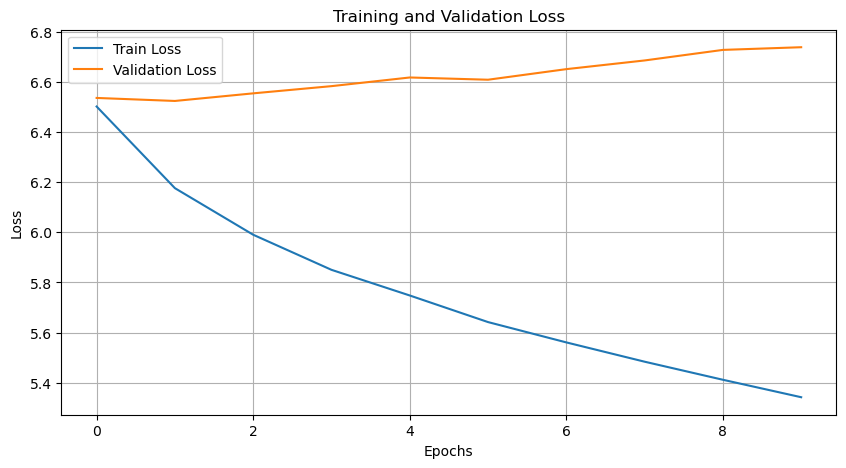

입력: 오바마는 대통령이다.
번역: obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama obama\n
입력: 시민들은 도시 속에 산다.
번역: thesss inhabitssssssssssssssssssssssss\n
입력: 커피는 필요 없다.
번역: the ideas not known t known t known t known t known t known t known t known t know\n
입력: 일곱 명의 사망자가 발생했다.
번역: thousands victim victim killed tuesday sunday people were killed tuesday sunday sunday , least people were killed tuesday sunday sunday , least people\n


In [12]:
# 손실 그래프 시각화
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 번역 테스트 함수
def translate_sentence(sentence, model, kor_tokenizer, eng_tokenizer, device, max_len=30):
    model.eval()
    
    # 입력 문장 전처리 및 토큰화
    src_tokens = preprocess_korean(sentence)
    src_ids = [kor_tokenizer.bos_id()] + kor_tokenizer.encode(' '.join(src_tokens)) + [kor_tokenizer.eos_id()]
    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_ids = [eng_tokenizer.bos_id()]
    for _ in range(max_len):
        trg_tensor = torch.LongTensor([trg_ids[-1]]).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden, encoder_outputs)
        pred_token = output.argmax(1).item()
        trg_ids.append(pred_token)
        if pred_token == eng_tokenizer.eos_id():
            break
    
    # 결과 디코딩
    trg_tokens = eng_tokenizer.decode(trg_ids[1:-1]) # <bos>와 <eos> 제외
    return trg_tokens

# 테스트 문장
test_sentences = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

for sentence in test_sentences:
    translation = translate_sentence(sentence, model, kor_tokenizer, eng_tokenizer, device)
    print(f"입력: {sentence}")
    print(f"번역: {translation}\\n")

⚠️ 경고: 지정된 경로에 폰트 파일이 없습니다. (/usr/share/fonts/truetype/nanum/NanumGothic.ttf)
그래프의 한글이 깨질 수 있습니다. 폰트 경로를 확인하거나 설치해주세요.


/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/conda/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/opt/co

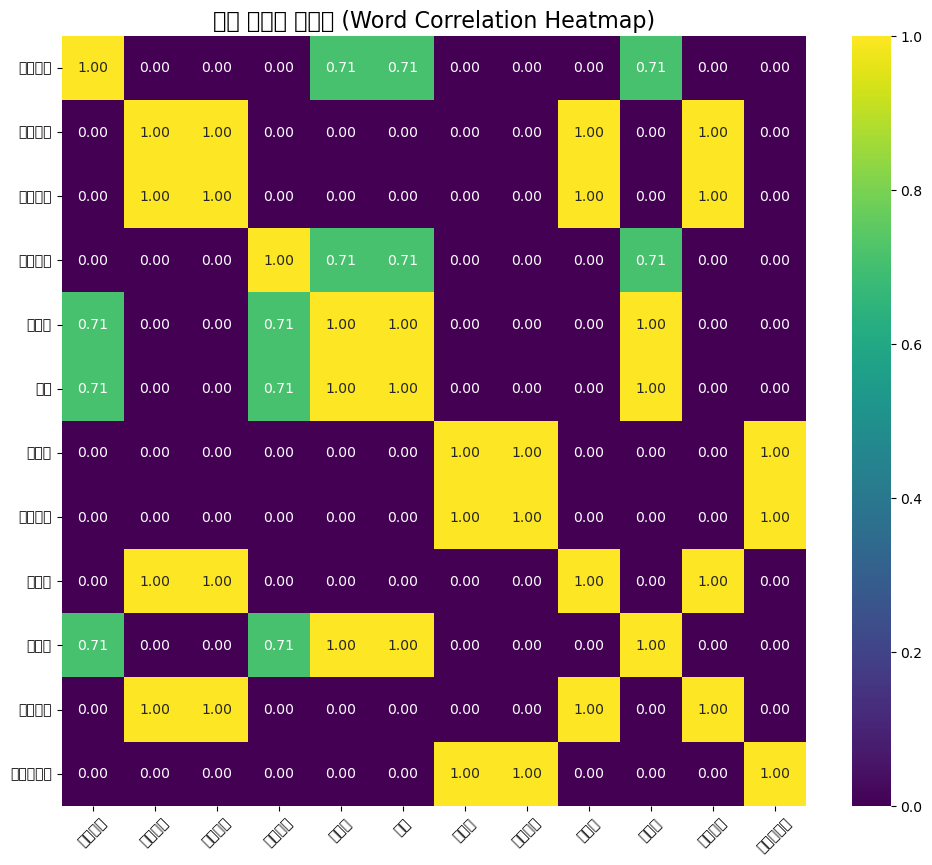

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import platform
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows, Mac, Linux/Colab에 맞게 자동 설정)
system_name = platform.system()
if system_name == 'Windows':
    font_path = 'c:/Windows/Fonts/malgun.ttf'
elif system_name == 'Darwin': # Mac
    font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
else: # Linux/Colab
    # Colab, Kaggle 등 Linux 환경에서는 아래 코드 실행 후 런타임 재시작 필요
    # !sudo apt-get install -y fonts-nanum
    # !fc-cache -fv
    # !rm ~/.cache/matplotlib -rf
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 지정된 경로에 폰트가 있는지 확인
try:
    font_prop = fm.FontProperties(fname=font_path)
    plt.rc('font', family=font_prop.get_name())
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
    print(f"✅ 폰트가 성공적으로 설정되었습니다: {font_prop.get_name()}")
except FileNotFoundError:
    print(f"⚠️ 경고: 지정된 경로에 폰트 파일이 없습니다. ({font_path})")
    print("그래프의 한글이 깨질 수 있습니다. 폰트 경로를 확인하거나 설치해주세요.")


def plot_word_correlation_heatmap(corpus):
    """
    주어진 문장 모음(corpus)에서 단어 간 연관성 히트맵을 생성합니다.

    Args:
        corpus (list of str): 분석할 문장들의 리스트.
    """
    if not corpus:
        print("입력된 문장이 없습니다.")
        return

    # 1. TF-IDF 벡터화
    # 단어의 중요도를 계산하여 문장을 벡터로 변환합니다.
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(corpus)

    # 2. 단어 벡터 간 코사인 유사도 계산
    # (문서, 단어) 행렬을 (단어, 문서)로 전치하여 단어 벡터를 만듭니다.
    # 각 단어가 어떤 문서들에서 중요한지를 나타내는 벡터가 됩니다.
    word_vectors = tfidf_matrix.T
    correlation_matrix = cosine_similarity(word_vectors)

    # 3. 히트맵 시각화
    words = vectorizer.get_feature_names_out()
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix,
        xticklabels=words,
        yticklabels=words,
        cmap='viridis', # 제공된 코드와 동일한 컬러맵 사용
        annot=True,     # 각 셀에 유사도 값 표시
        fmt=".2f"       # 소수점 둘째 자리까지 표시
    )
    plt.title('단어 연관성 히트맵 (Word Correlation Heatmap)', fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# --- 실행 부분 ---
# 분석하고 싶은 문장들을 리스트 형태로 준비합니다.
korean_corpus = [
    '강아지는 귀여운 동물 입니다',
    '고양이도 귀여운 동물 입니다',
    '강아지와 고양이는 사이가 좋습니다',
    '사람들은 동물을 좋아합니다'
]

# 함수를 호출하여 히트맵을 생성합니다.
plot_word_correlation_heatmap(korean_corpus)

손실그래프를 통해 학습초반부터 심각한 과적화가 이루어짐을 확인\n
실제 출력을 통해서도 같은 단어가 반복되거나 관계없는단어들이 함께 나옴을 확인
이를 해결하기 위해 

dropout 0.5 -> 0.8
learning rate 0.001 -> 0.0005
